# 서울시 상권 데이터 탐색적 분석 (EDA)
## 도시의 경제적 활력 지수(Economic Vitality Index) 개발을 위한 데이터 분석

## 목표
1. 상권별/업종별 매출 패턴 분석
2. 시간대/요일별 소비 행태 파악
3. 핫존(성장 상권) vs 콜드존(쇠퇴 상권) 구별
4. 경제 활력 지수 개발을 위한 인사이트 도출

## 0. 라이브러리 및 데이터 로드

In [ ]:
# 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 한글 폰트 설정
import matplotlib.font_manager as fm

font_list = [f.name for f in fm.fontManager.ttflist]
if 'AppleGothic' in font_list:
    plt.rcParams['font.family'] = 'AppleGothic'
elif 'Malgun Gothic' in font_list:
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif 'NanumGothic' in font_list:
    plt.rcParams['font.family'] = 'NanumGothic'
else:
    print("경고: 한글 폰트를 찾을 수 없습니다.")

plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"사용 중인 폰트: {plt.rcParams['font.family']}")

In [ ]:
# 데이터 로드
df = pd.read_pickle('data/seoul_2024_preprocessed.pkl')

print(f"데이터: {len(df):,}행 x {len(df.columns)}열")
print(f"메모리: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\n분석 기간: {df['년도'].unique()[0]}년 {list(df['분기'].unique())}분기")
print(f"상권: {df['TRDAR_CD'].nunique():,}개")
print(f"업종: {df['SVC_INDUTY_CD_NM'].nunique()}개")
print(f"총 매출: {df['THSMON_SELNG_AMT'].sum() / 1e12:.2f}조원")

df.head()

## 1. 상권 유형별 분석

In [ ]:
# 상권 구분별 매출 현황
trdar_summary = df.groupby('TRDAR_SE_CD_NM').agg({
    'TRDAR_CD': 'nunique',
    'THSMON_SELNG_AMT': ['sum', 'mean'],
    'THSMON_SELNG_CO': ['sum', 'mean'],
    '평균거래단가': 'mean',
    '야간매출비율': 'mean',
    '주말매출비율': 'mean',
    '청년층비율': 'mean'
}).round(2)

trdar_summary.columns = ['상권수', '총매출액', '평균매출액', '총거래건수', '평균거래건수', 
                         '평균거래단가', '야간매출비율', '주말매출비율', '청년층비율']
trdar_summary = trdar_summary.sort_values('총매출액', ascending=False)
trdar_summary

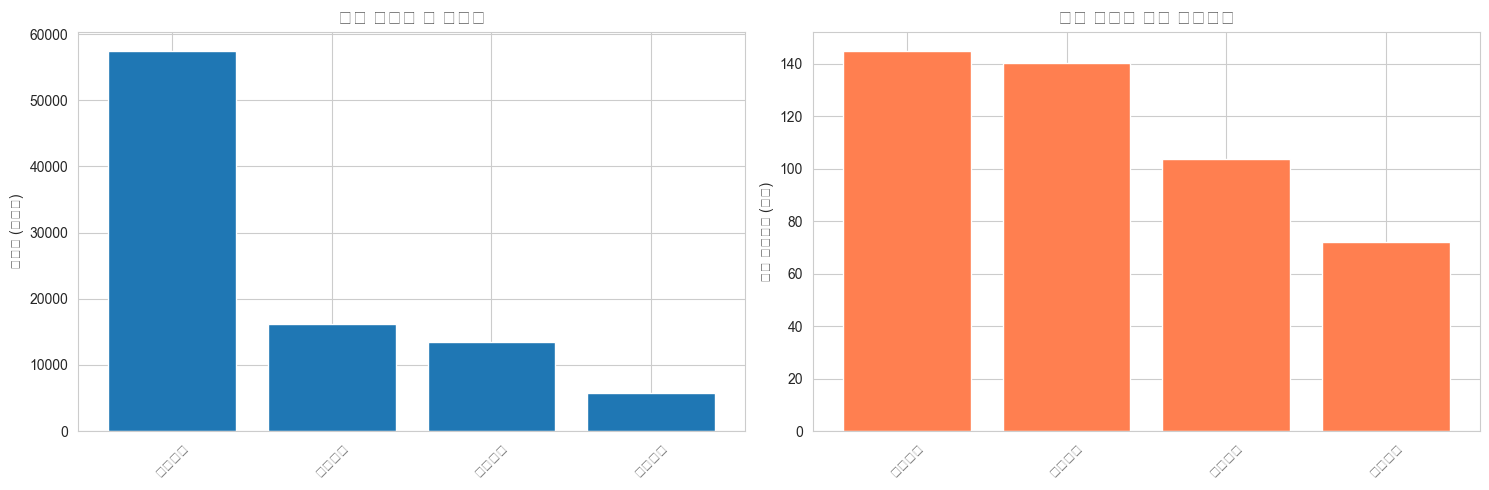

In [4]:
# 상권 구분별 매출 비교 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. 상권별 총 매출
trdar_sales = df.groupby('TRDAR_SE_CD_NM')['THSMON_SELNG_AMT'].sum().sort_values(ascending=False)
axes[0].bar(trdar_sales.index, trdar_sales.values / 1e9)
axes[0].set_title('상권 구분별 총 매출액', fontsize=14, fontweight='bold')
axes[0].set_ylabel('매출액 (십억원)')
axes[0].tick_params(axis='x', rotation=45)

# 2. 상권별 평균 거래단가
trdar_price = df.groupby('TRDAR_SE_CD_NM')['평균거래단가'].mean().sort_values(ascending=False)
axes[1].bar(trdar_price.index, trdar_price.values / 1000, color='coral')
axes[1].set_title('상권 구분별 평균 거래단가', fontsize=14, fontweight='bold')
axes[1].set_ylabel('평균 거래단가 (천원)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 2. 업종별 분석

In [ ]:
# 업종별 매출 TOP 20
industry_summary = df.groupby('SVC_INDUTY_CD_NM').agg({
    'THSMON_SELNG_AMT': ['sum', 'mean', 'count'],
    '야간매출비율': 'mean',
    '주말매출비율': 'mean',
    '청년층비율': 'mean',
    '주력소비층비율': 'mean'
}).round(2)

industry_summary.columns = ['총매출액', '평균매출액', '데이터수', '야간매출비율', 
                            '주말매출비율', '청년층비율', '주력소비층비율']
industry_summary = industry_summary.sort_values('총매출액', ascending=False)
industry_summary.head(20)

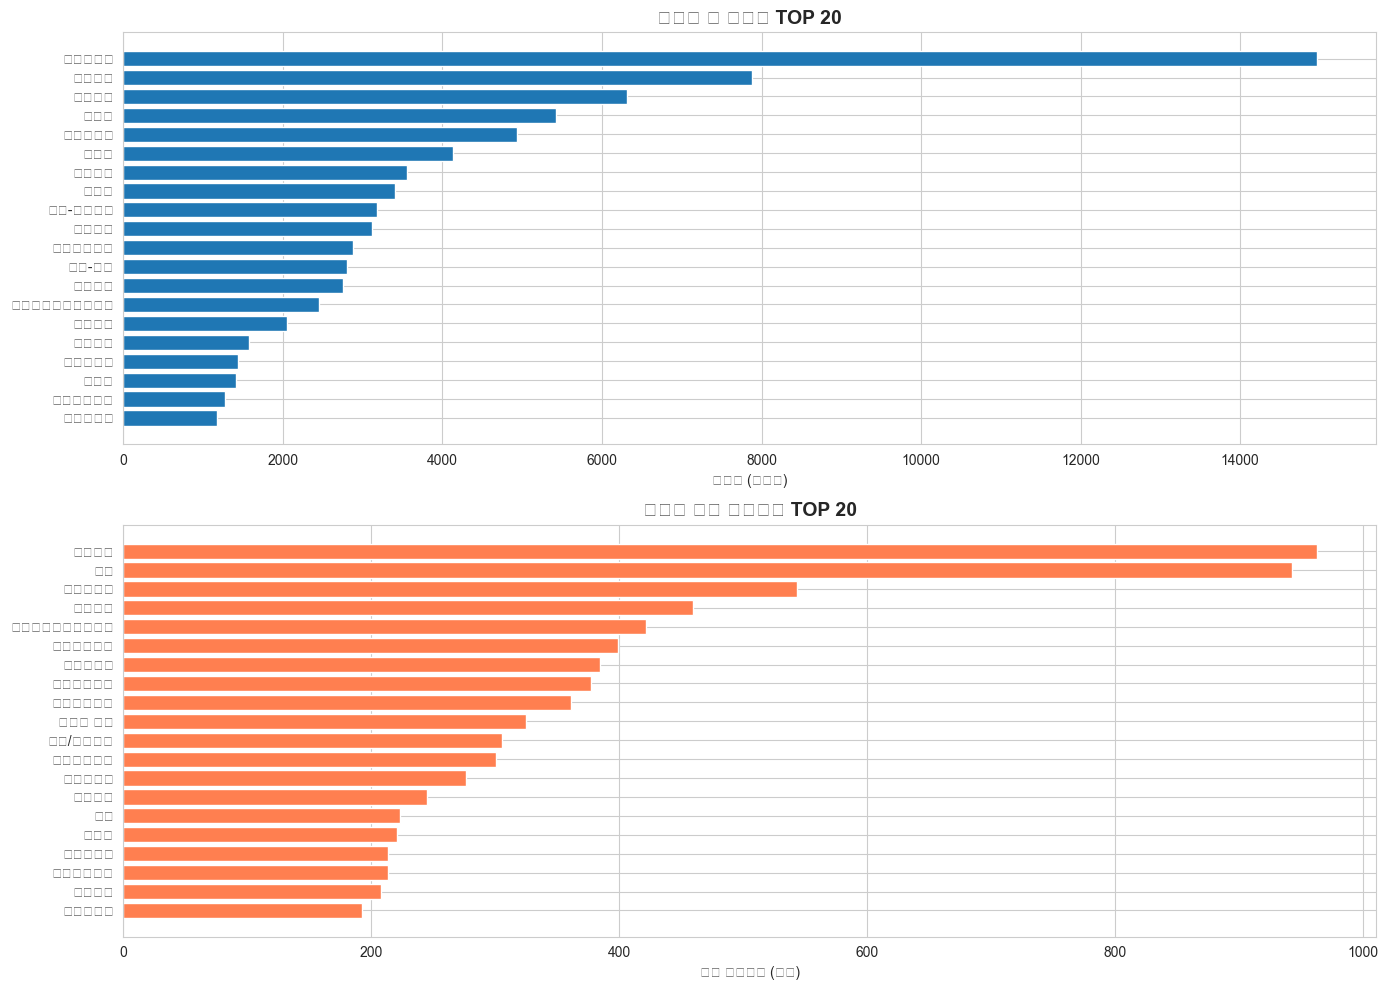

In [6]:
# TOP 20 업종 시각화
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 1. 총 매출 TOP 20
top20_sales = df.groupby('SVC_INDUTY_CD_NM')['THSMON_SELNG_AMT'].sum().sort_values(ascending=False).head(20)
axes[0].barh(range(len(top20_sales)), top20_sales.values / 1e9)
axes[0].set_yticks(range(len(top20_sales)))
axes[0].set_yticklabels(top20_sales.index)
axes[0].set_xlabel('매출액 (십억원)')
axes[0].set_title('업종별 총 매출액 TOP 20', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# 2. 평균 거래단가 TOP 20
top20_price = df.groupby('SVC_INDUTY_CD_NM')['평균거래단가'].mean().sort_values(ascending=False).head(20)
axes[1].barh(range(len(top20_price)), top20_price.values / 1000, color='coral')
axes[1].set_yticks(range(len(top20_price)))
axes[1].set_yticklabels(top20_price.index)
axes[1].set_xlabel('평균 거래단가 (천원)')
axes[1].set_title('업종별 평균 거래단가 TOP 20', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 3. 시간대별 소비 패턴 분석

In [ ]:
# 시간대별 매출 분포
time_zones = ['TMZON_00_06_SELNG_AMT', 'TMZON_06_11_SELNG_AMT', 'TMZON_11_14_SELNG_AMT',
              'TMZON_14_17_SELNG_AMT', 'TMZON_17_21_SELNG_AMT', 'TMZON_21_24_SELNG_AMT']
time_labels = ['00-06시', '06-11시', '11-14시', '14-17시', '17-21시', '21-24시']

time_sales = df[time_zones].sum()
time_sales.index = time_labels

print("=== 시간대별 매출 ===")
for label, value in time_sales.items():
    pct = value / time_sales.sum() * 100
    print(f"{label}: {value/1e9:>10.2f}억원 ({pct:>5.1f}%)")

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].bar(time_labels, time_sales.values / 1e9, color='steelblue')
axes[0].set_title('시간대별 총 매출액', fontsize=14, fontweight='bold')
axes[0].set_ylabel('매출액 (십억원)')
axes[0].tick_params(axis='x', rotation=45)

axes[1].pie(time_sales.values, labels=time_labels, autopct='%1.1f%%', startangle=90)
axes[1].set_title('시간대별 매출 비중', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# 야간 경제 활성화 업종 (17시 이후)
night_industry = df.groupby('SVC_INDUTY_CD_NM').agg({
    '야간매출비율': 'mean',
    'THSMON_SELNG_AMT': 'sum'
}).round(2)

night_industry.columns = ['야간매출비율', '총매출액']
night_industry = night_industry[night_industry['총매출액'] > df['THSMON_SELNG_AMT'].quantile(0.25)]
night_industry = night_industry.sort_values('야간매출비율', ascending=False)

print("=== 야간 경제 활성화 업종 TOP 20 ===")
night_industry.head(20)

## 4. 요일별 소비 패턴 분석

In [ ]:
# 요일별 매출 분포
days = ['MON_SELNG_AMT', 'TUES_SELNG_AMT', 'WED_SELNG_AMT', 'THUR_SELNG_AMT',
        'FRI_SELNG_AMT', 'SAT_SELNG_AMT', 'SUN_SELNG_AMT']
day_labels = ['월', '화', '수', '목', '금', '토', '일']

day_sales = df[days].sum()
day_sales.index = day_labels

print("=== 요일별 매출 ===")
for label, value in day_sales.items():
    pct = value / day_sales.sum() * 100
    print(f"{label}요일: {value/1e9:>10.2f}억원 ({pct:>5.1f}%)")

weekday_total = df['MDWK_SELNG_AMT'].sum()
weekend_total = df['WKEND_SELNG_AMT'].sum()
print(f"\n주중: {weekday_total/1e12:.2f}조원 ({weekday_total/(weekday_total+weekend_total)*100:.1f}%)")
print(f"주말: {weekend_total/1e12:.2f}조원 ({weekend_total/(weekday_total+weekend_total)*100:.1f}%)")

# 시각화
plt.figure(figsize=(12, 5))
plt.plot(day_labels, day_sales.values / 1e9, marker='o', linewidth=2, markersize=8)
plt.fill_between(range(len(day_labels)), day_sales.values / 1e9, alpha=0.3)
plt.title('요일별 매출 추이', fontsize=14, fontweight='bold')
plt.ylabel('매출액 (십억원)')
plt.xlabel('요일')
plt.grid(True, alpha=0.3)
plt.axvline(x=4.5, color='red', linestyle='--', alpha=0.5, label='주중/주말 경계')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 주말 활성화 업종
weekend_industry = df.groupby('SVC_INDUTY_CD_NM').agg({
    '주말매출비율': 'mean',
    'THSMON_SELNG_AMT': 'sum'
}).round(2)

weekend_industry.columns = ['주말매출비율', '총매출액']
weekend_industry = weekend_industry[weekend_industry['총매출액'] > df['THSMON_SELNG_AMT'].quantile(0.25)]
weekend_industry = weekend_industry.sort_values('주말매출비율', ascending=False)

print("=== 주말 활성화 업종 TOP 20 ===")
weekend_industry.head(20)

## 5. 인구통계학적 분석 (성별, 연령대)

In [ ]:
# 성별 매출 분석
male_total = df['ML_SELNG_AMT'].sum()
female_total = df['FML_SELNG_AMT'].sum()
total = male_total + female_total

print("=== 성별 매출 ===")
print(f"남성: {male_total/1e12:.2f}조원 ({male_total/total*100:.1f}%)")
print(f"여성: {female_total/1e12:.2f}조원 ({female_total/total*100:.1f}%)")

# 성별 선호 업종
gender_pref = df.groupby('SVC_INDUTY_CD_NM').agg({
    'ML_SELNG_AMT': 'sum',
    'FML_SELNG_AMT': 'sum',
    'THSMON_SELNG_AMT': 'sum'
})
gender_pref['남성비율'] = (gender_pref['ML_SELNG_AMT'] / gender_pref['THSMON_SELNG_AMT'] * 100).round(2)
gender_pref['여성비율'] = (gender_pref['FML_SELNG_AMT'] / gender_pref['THSMON_SELNG_AMT'] * 100).round(2)

print("\n=== 남성 선호 업종 TOP 10 ===")
print(gender_pref[gender_pref['THSMON_SELNG_AMT'] > df['THSMON_SELNG_AMT'].quantile(0.25)]
      .nlargest(10, '남성비율')[['남성비율', '여성비율']])

print("\n=== 여성 선호 업종 TOP 10 ===")
print(gender_pref[gender_pref['THSMON_SELNG_AMT'] > df['THSMON_SELNG_AMT'].quantile(0.25)]
      .nlargest(10, '여성비율')[['남성비율', '여성비율']])

In [ ]:
# 연령대별 매출 분석
age_cols = ['AGRDE_10_SELNG_AMT', 'AGRDE_20_SELNG_AMT', 'AGRDE_30_SELNG_AMT',
            'AGRDE_40_SELNG_AMT', 'AGRDE_50_SELNG_AMT', 'AGRDE_60_ABOVE_SELNG_AMT']
age_labels = ['10대', '20대', '30대', '40대', '50대', '60대+']

age_sales = df[age_cols].sum()
age_sales.index = age_labels

print("=== 연령대별 매출 ===")
for label, value in age_sales.items():
    pct = value / age_sales.sum() * 100
    print(f"{label}: {value/1e9:>10.2f}억원 ({pct:>5.1f}%)")

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].bar(age_labels, age_sales.values / 1e9, color='mediumpurple')
axes[0].set_title('연령대별 총 매출액', fontsize=14, fontweight='bold')
axes[0].set_ylabel('매출액 (십억원)')

axes[1].pie(age_sales.values, labels=age_labels, autopct='%1.1f%%', startangle=90)
axes[1].set_title('연령대별 매출 비중', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 6. 경제 활력 지수 관련 지표 분석

In [ ]:
# 경제 활력 지표 기술통계
vitality_cols = ['야간매출비율', '주말매출비율', '청년층비율', '주력소비층비율', 
                 '시니어층비율', '평균거래단가', '요일별변동계수']

print("=== 경제 활력 지표 기술통계 ===")
print(df[vitality_cols].describe())

In [ ]:
# 지표 간 상관관계
corr_cols = ['THSMON_SELNG_AMT', '야간매출비율', '주말매출비율', '청년층비율', 
             '주력소비층비율', '평균거래단가', '요일별변동계수']
correlation = df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('경제 활력 지표 간 상관관계', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n=== 상관계수 ===")
print(correlation)

In [ ]:
# 상권별 경제 활력 지수 계산
from sklearn.preprocessing import MinMaxScaler

vitality_by_trdar = df.groupby('TRDAR_CD_NM').agg({
    'THSMON_SELNG_AMT': 'sum',
    '야간매출비율': 'mean',
    '주말매출비율': 'mean',
    '청년층비율': 'mean',
    '주력소비층비율': 'mean',
    '평균거래단가': 'mean',
    '요일별변동계수': 'mean'
}).round(2)

# 정규화 (0-100)
scaler = MinMaxScaler(feature_range=(0, 100))

vitality_by_trdar['매출규모_점수'] = scaler.fit_transform(vitality_by_trdar[['THSMON_SELNG_AMT']])
vitality_by_trdar['야간경제_점수'] = scaler.fit_transform(vitality_by_trdar[['야간매출비율']])
vitality_by_trdar['주말활성_점수'] = scaler.fit_transform(vitality_by_trdar[['주말매출비율']])
vitality_by_trdar['청년층활성_점수'] = scaler.fit_transform(vitality_by_trdar[['청년층비율']])
vitality_by_trdar['주력소비층_점수'] = scaler.fit_transform(vitality_by_trdar[['주력소비층비율']])
vitality_by_trdar['소비안정성_점수'] = 100 - scaler.fit_transform(vitality_by_trdar[['요일별변동계수']])

# 종합 점수 (가중평균)
vitality_by_trdar['경제활력지수'] = (
    vitality_by_trdar['매출규모_점수'] * 0.25 +
    vitality_by_trdar['야간경제_점수'] * 0.20 +
    vitality_by_trdar['주말활성_점수'] * 0.20 +
    vitality_by_trdar['청년층활성_점수'] * 0.15 +
    vitality_by_trdar['주력소비층_점수'] * 0.10 +
    vitality_by_trdar['소비안정성_점수'] * 0.10
).round(2)

vitality_by_trdar = vitality_by_trdar.sort_values('경제활력지수', ascending=False)

print("=== 핫존 TOP 20 (활력 높은 상권) ===")
print(vitality_by_trdar.head(20)[['경제활력지수', '매출규모_점수', '야간경제_점수', 
                                    '주말활성_점수', '청년층활성_점수', '소비안정성_점수']])

print("\n=== 콜드존 BOTTOM 20 (활력 낮은 상권) ===")
print(vitality_by_trdar.tail(20)[['경제활력지수', '매출규모_점수', '야간경제_점수', 
                                    '주말활성_점수', '청년층활성_점수', '소비안정성_점수']])

In [ ]:
# 경제활력지수 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 히스토그램
axes[0].hist(vitality_by_trdar['경제활력지수'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(vitality_by_trdar['경제활력지수'].mean(), color='red', 
                linestyle='--', label=f"평균: {vitality_by_trdar['경제활력지수'].mean():.2f}")
axes[0].axvline(vitality_by_trdar['경제활력지수'].median(), color='green', 
                linestyle='--', label=f"중앙값: {vitality_by_trdar['경제활력지수'].median():.2f}")
axes[0].set_title('경제활력지수 분포', fontsize=14, fontweight='bold')
axes[0].set_xlabel('경제활력지수')
axes[0].set_ylabel('상권 수')
axes[0].legend()

# 박스플롯
axes[1].boxplot(vitality_by_trdar['경제활력지수'], vert=True)
axes[1].set_title('경제활력지수 박스플롯', fontsize=14, fontweight='bold')
axes[1].set_ylabel('경제활력지수')

plt.tight_layout()
plt.show()

print(f"\n평균: {vitality_by_trdar['경제활력지수'].mean():.2f}")
print(f"중앙값: {vitality_by_trdar['경제활력지수'].median():.2f}")
print(f"표준편차: {vitality_by_trdar['경제활력지수'].std():.2f}")
print(f"범위: {vitality_by_trdar['경제활력지수'].min():.2f} ~ {vitality_by_trdar['경제활력지수'].max():.2f}")

## 7. 주요 인사이트 및 다음 단계

### 📌 주요 발견사항

*(위의 분석 결과를 바탕으로 작성)*

1. **상권 유형별 특징**
   - [분석 후 작성]

2. **시간대/요일별 패턴**
   - [분석 후 작성]

3. **핫존 vs 콜드존**
   - [분석 후 작성]

### 🎯 다음 단계

1. **추가 데이터 수집**
   - 서울시 유동인구 데이터
   - 전국상가업소정보 (점포 수, 분포)
   - 시계열 데이터 (여러 분기 비교)

2. **고도화된 분석**
   - 클러스터링 (상권 유형 분류)
   - 시계열 분석 (성장/쇠퇴 트렌드)
   - 공간 분석 (지도 시각화)

3. **정책 제언**
   - 도시재생 타깃 지역 선정
   - 업종별 창업 추천 지역
   - 활성화 전략 수립